## Domain
<img src="https://i.imgur.com/V5uSQdp.jpg" alt="drawing" width="300"/>

The state can be represented as a string (e.g. `"XR.Y"` for the above)

The observation model is defined by three things:
* The **joint probability distribution Pr(X, Y)**, where X and Y are locations of objects X and Y, that can take values 0, 1, …, HallwayLength (In the example above, HallwayLength = 5)
    * In the examples, I set Pr(X,Y) with a simple rule: Pr(x,y) = const if `SpatialCorr(x,y)` is True, and Pr(x,y) = 0 otherwise. `SpatialCorr` is a predicate of x and y. I can define it however I want.
* **range_x**: The range of the detector for object X.
    The robot can detect X if |R-X| <= range_x
* **range_y**: The range of the detector for object Y. Same rule as above


## Investigation

The code here uses or borrows from `hallway_xy.py`

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Include parent directory into path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from hallway_xy import main as run_domain
from hallway_xy import str_to_setting, indicator, plot_belief, plot_true_state,\
    HSTrueState, HSAgent, HSObservation, HSAction
from probability import TabularDistribution
import pomdp_py
import matplotlib.pyplot as plt

In [2]:
# 4 kinds of SpatialCorr functions
def spatially_apart(x, y):
    return abs(x - y) > 1
def spatially_close(x, y):
    return abs(x - y) <= 1
def spatially_exact(x, y):
    return abs(x - y) == 2
def spatially_independent(x,y):
    return True

In [3]:
# ranges
range_x = 0
range_y = 1

### Simple Setting, spatially exact

Using inequality as spatial correlation could make it is hard for us to think what is the optimal POMDP policy. Therefore, we look at a simpler case below, with `spatially_exact` relation. Our goal here is to determine whether SARSOP/VI/POUCT is actually capable of producing the optimal policy.
```
def spatially_exact(x, y):
    return abs(x - y) == 2
```

Note that the observation of X or Y does not involve location (This is important to understand the belief update behavior).

In [6]:
simple = "X.YR"

In the above setting `X.YR`, the sequence of actions produced by the optimal policy must be:

1) **lookY**. Rationale: Declare, left, right are not sensible to be the first action. The choice is between lookX and lookY. For lookX, the robot believes with 75% chance the observation will be nothing, which results in an updated belief that is uniform over 3 out of 4 locations. For lookY, regardless of the observation received, the resulting updated belief will be uniform over 2 out of 4 locations. I calculated the value of two policy trees, one with lookX as the root and one with lookY as the root, and the subsequent actions are optimal under the uniform initial belief. I found that the tree rooted by lookX has a value of 8.29061 and the tree rooted by lookY has a value of 8.370405. So, lookY first is a better choice.

```
The value of the policy tree rooted by lookX, with optimal subtree under uniform initial belief:
0 + 0.95*(0.25*10 + 0.75*(0+0.95*(0+0.95*(1/3*10+2/3*(0+0.95*(0+0.95*(0.5*10+0.5*(0+0.95 *10))))))))
= 8.290619570312499

The value of the policy tree rooted by lookY, with optimal subtree under uniform initial belief:
0+0.95*(0.5*(0+0.95*(0+0.95*(0+0.95*(0.5*10+0.5*(0+0.95*10)))))+0.5*(0+0.95*(0.5*10+0.5*(0+0.95*10))))
= 8.370405468749999    
```

2) **left**. Rationale: After belief update, the left two locations will have equal chance. Then, lookY or lookX makes no sense because they do not change the belief. Declare makes no sense because the robot is on top of a cell with zero probability that X is there. Right is not valid. So left.

3) **left**. Rationale: Now, the robot should be at location 2. lookX does not change belief, so it won't be chosen. lookY also won't change the belief, because the robot knows observing `nothing` is impossible (if so X must be at 2 but the robot has zero belief in X=2), and thus it will surely observe `Y` which does not change the belief. Going to the right is clearly not a good idea (moving away from X), and Declare is not acceptable. Thus left is the only option.

3) **lookX or lookY**. Rationale: Now, the robot should be at location 1. It has 0.5 belief at X=1. Declare makes no sense. Right makes no sense. Between lookX and lookY, they are actually equivalent. Taking either lookX or lookY will result in the belief mass to concentrate entirely on one location as a result. Therefore, lookX or lookY are both fine.

4) **left**. Rationale: The robot has 100% belief in X=0. So the only optimal thing to do is to move on top of it.

5) **Declare**. Rationale: Now, the robot is on top of a location it believes 100% that X is there. So it will Declare and believe that would give high reward.

In short, **lookY**, **left**, **left**, **(lookX | lookY)**, **left**, **Declare** should be the action sequence corresponding to the optimal POMDP policy.

#### SARSOP

X.YR
[step=1] action=lookY, observation=Y, reward=0, cum_reward=0.00000
X.R.
[step=2] action=left, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=3] action=left, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=4] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=5] action=left, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=6] action=Declare, observation=nothing, reward=10, cum_reward=7.73781
Done. Discounted cumulative reward: 7.73781


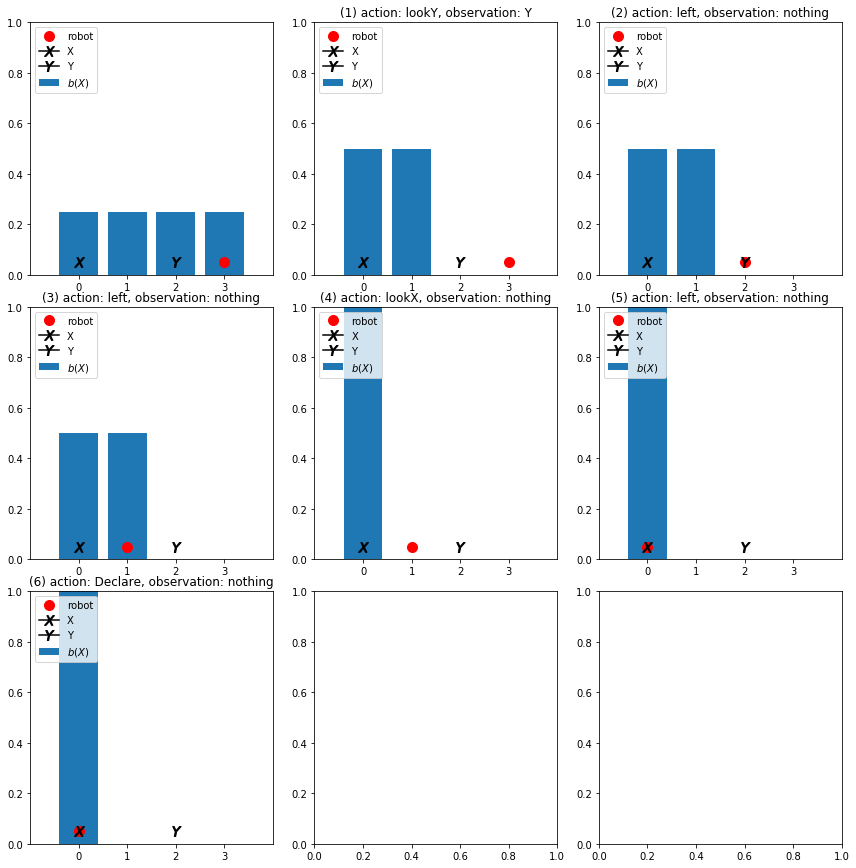

In [7]:
# Sarsop
run_domain(solver="sarsop", setting=simple,
          spatial_corr_func=spatially_exact,
          range_x=range_x, range_y=range_y,
          using_jupyter=True)

Output by SARSOP:
```
Loading the model ...
  input file   : ./hallway_search.pomdp
  loading time : 0.00s 

SARSOP initializing ...
  initialization time : 0.00s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0       0       0        0          185.494    185.494     5        1        
 0       9       47       167.408    167.408    -2.84217e-14 28       17       
-------------------------------------------------------------------------------

SARSOP finishing ...
  target precision reached
  target precision  : 0.000000
  precision reached : -0.000000 

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0       9       47       167.408    167.408    -2.84217e-14 26       17       
-------------------------------------------------------------------------------


```

#### Value Iteration with Pruning (pomdp-solve by Anthony Cassandra)

X.YR
[step=1] action=lookY, observation=Y, reward=0, cum_reward=0.00000
X.R.
[step=2] action=left, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=3] action=left, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=4] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=5] action=left, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=6] action=Declare, observation=nothing, reward=10, cum_reward=7.73781
Done. Discounted cumulative reward: 7.73781


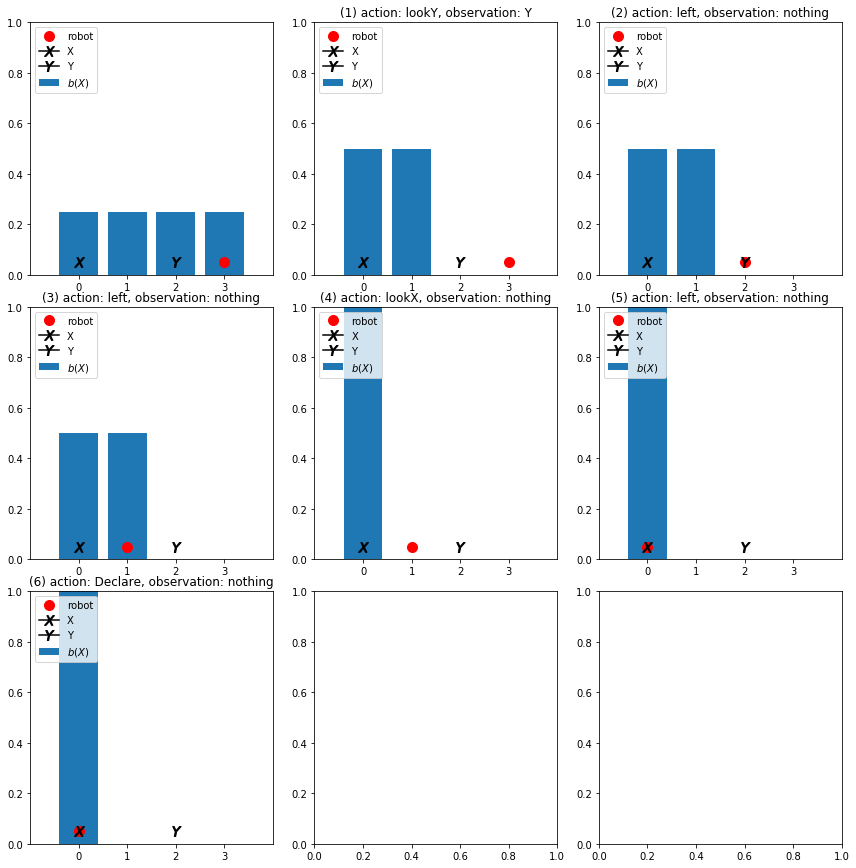

In [8]:
run_domain(solver="vi", setting=simple,
          spatial_corr_func=spatially_exact,
          range_x=range_x, range_y=range_y,
          using_jupyter=True, vi_options=['-horizon', 7])

Output by pomdp-solve:
```
...
witness_points = false
- - - - - - - - - - - - - - - - - - - -
[Initializing POMDP ... done.]
[Initial policy has 1 vectors.]
++++++++++++++++++++++++++++++++++++++++
Epoch: 1...2 vectors in 0.00 secs. (0.00 total) (err=inf)
Epoch: 2...4 vectors in 0.00 secs. (0.00 total) (err=inf)
Epoch: 3...14 vectors in 0.00 secs. (0.00 total) (err=inf)
Epoch: 4...43 vectors in 0.01 secs. (0.01 total) (err=inf)
Epoch: 5...120 vectors in 0.13 secs. (0.14 total) (err=inf)
Epoch: 6...121 vectors in 0.91 secs. (1.05 total) (err=inf)
Epoch: 7...223 vectors in 1.23 secs. (2.29 total) (err=inf)
++++++++++++++++++++++++++++++++++++++++
Solution found.  See file:
        hallway_search.alpha
        hallway_search.pg
++++++++++++++++++++++++++++++++++++++++
User time = 0 hrs., 0 mins, 2.30 secs. (= 2.30 secs)
System time = 0 hrs., 0 mins, 0.00 secs. (= 0.00 secs)
Total execution time = 0 hrs., 0 mins, 2.30 secs. (= 2.30 secs)

```

#### POUCT

X.YR
[step=1] action=lookY, observation=Y, reward=0, cum_reward=0.00000
X.R.
[step=2] action=left, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=3] action=left, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=4] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=5] action=left, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=6] action=Declare, observation=nothing, reward=10, cum_reward=7.73781
Done. Discounted cumulative reward: 7.73781


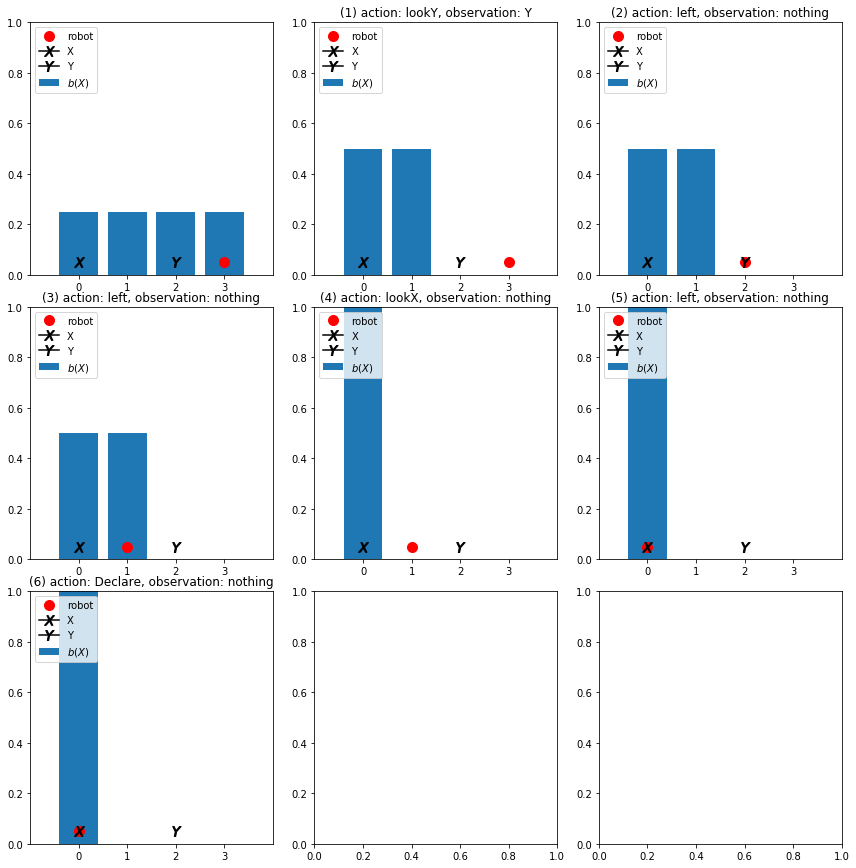

In [9]:
# Try 1
run_domain(solver="pouct", setting=simple,
         spatial_corr_func=spatially_apart,
         range_x=range_x, range_y=range_y,
         using_jupyter=True)

X.YR
[step=1] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
X.R.
[step=2] action=left, observation=nothing, reward=0, cum_reward=0.00000
X.R.
[step=3] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=4] action=left, observation=nothing, reward=0, cum_reward=0.00000
XRY.
[step=5] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=6] action=left, observation=nothing, reward=0, cum_reward=0.00000
R.Y.
[step=7] action=Declare, observation=nothing, reward=10, cum_reward=7.35092
Done. Discounted cumulative reward: 7.35092


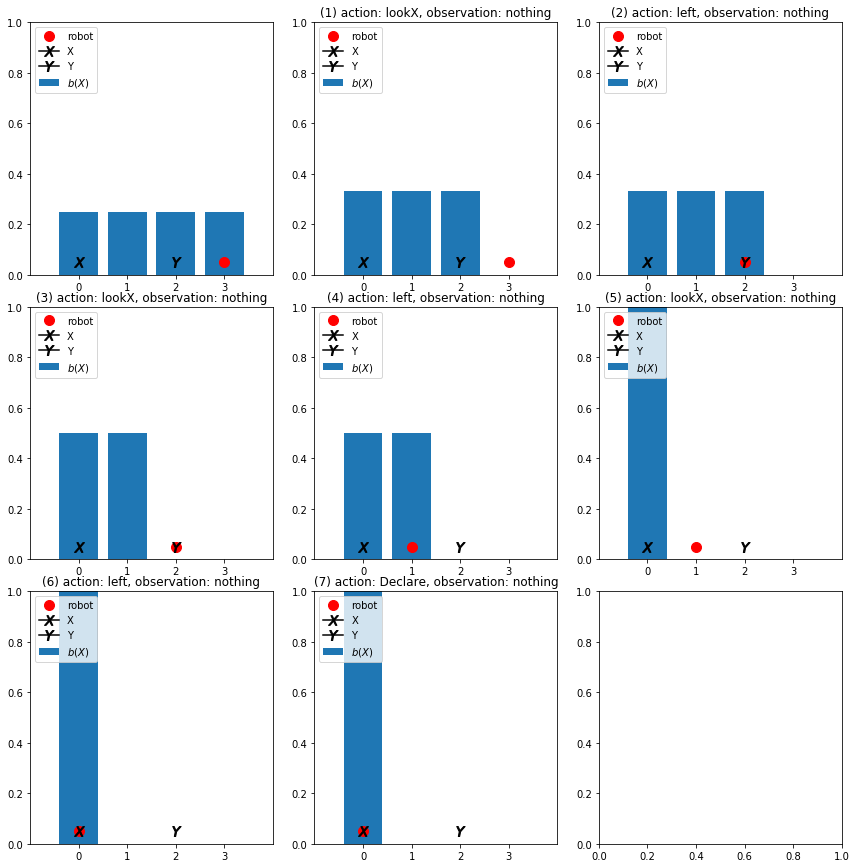

In [14]:
# Try 2
run_domain(solver="pouct", setting=simple,
         spatial_corr_func=spatially_apart,
         range_x=range_x, range_y=range_y,
         using_jupyter=True)

The action lookY is never taken in this run. I ran a couple of times and occassionally lookY is taken but it is never taken first. This means POUCT isn't producing optimal policy, which is expected.

#### Notes

* **With SARSOP and VI, the agent lookY first.** **They produced the same sequence of actions corresponding to the optimal policy.** The policy produced by SARSOP is the same every time I run it.

  * For VI, the number of alpha vectors can explode as the state space increases and planning horizon increases. This makes computing a policy extremely slow. Cutting off the computation results in bad policy.
 
  * For SARSOP, for small problems, it is really fast. But when the state space increases, it takes much longer time to “load model” (a step prior to computing the policy in the pomdpsol program) and then compute a policy. For small problems, even if it converged (i.e. precision = 0), the resulting policy doesn’t seem to be optimal to me in certain cases.

* **With POUCT however, the agent is unable to ALWAYS produce the policy that uses lookY.** The resulting policy may or may not perform as well as SARSOP/VI.

* I manully confirmed that the belief update is correct.

#### Question: Is SARSOP/VI policy the optimal policy?

**VI is an exact planner**. Technically, it should produce the optimal policy under the given horizon. 

SARSOP plans with unlimited horizon by default. VI does so too, but it is too slow (may take hours), so I have to set the horizon to be finite. This could lead to different policy than SARSOP. 

**SARSOP converges when the precision** (i.e. the difference between the upper and lower bound of value function) **is less than some threshold.** In the example above, **the precision reached 0. That should indicate that the policy is optimal.**


Also, **we have confirmed in the example case above VI and SARSOP produced the optimal policy.** Beyond this point I will use SARSOP only. This is our best bet - when the difference between upper and lower bound is really close to zero.

### Simple Setting, spatially apart
```
def spatially_apart(x, y):
    return abs(x - y) > 1
```

In [19]:
simple2 = "XR.Y"

XR.Y
[step=1] action=lookY, observation=nothing, reward=0, cum_reward=0.00000
XR.Y
[step=2] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
R..Y
[step=3] action=left, observation=nothing, reward=0, cum_reward=0.00000
R..Y
[step=4] action=Declare, observation=nothing, reward=10, cum_reward=8.57375
Done. Discounted cumulative reward: 8.57375


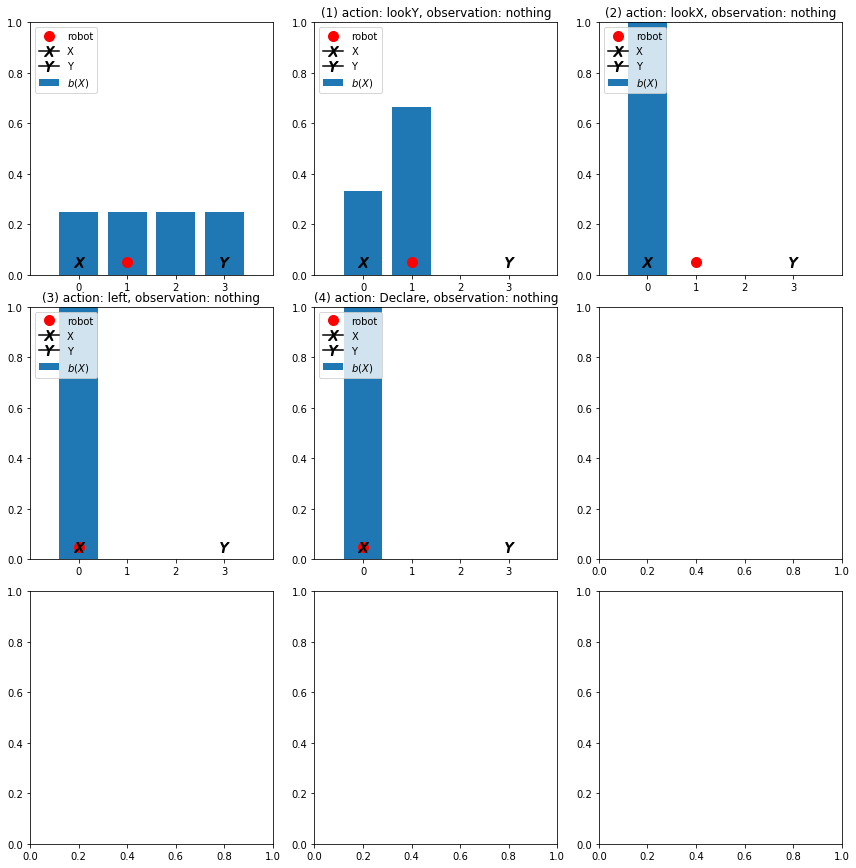

In [21]:
run_domain(solver="sarsop", setting=simple2,
          spatial_corr_func=spatially_apart,
          range_x=range_x, range_y=range_y,
          using_jupyter=True)

Output by SARSOP:
```
Loading the model ...
  input file   : ./hallway_search.pomdp
  loading time : 0.00s 

SARSOP initializing ...
  initialization time : 0.00s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0       0       0        0          190.125    190.125     5        1        
 0       7       50       161.265    167.612    6.34641     33       21       
 0       15      100      164.703    165.01     0.307788    54       34       
 0       16      103      164.703    164.703    0           48       34       
-------------------------------------------------------------------------------

SARSOP finishing ...
  target precision reached
  target precision  : 0.000000
  precision reached : 0.000000 

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0       16      103      164.703    164.703    0           46       34       
-------------------------------------------------------------------------------
```
The precision has converged to 0

Indeed, the robot took `lookY` first.

### Simple setting, spatially close
```
def spatially_close(x, y):
    return abs(x - y) <= 1
```

In [41]:
simple3 = "YXR..."   # will lookY but will lookX first

YXR...
[step=1] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
YR....
[step=2] action=left, observation=nothing, reward=0, cum_reward=0.00000
YR....
[step=3] action=lookY, observation=Y, reward=0, cum_reward=0.00000
YR....
[step=4] action=lookX, observation=X, reward=0, cum_reward=0.00000
YR....
[step=5] action=Declare, observation=nothing, reward=10, cum_reward=8.14506
Done. Discounted cumulative reward: 8.14506


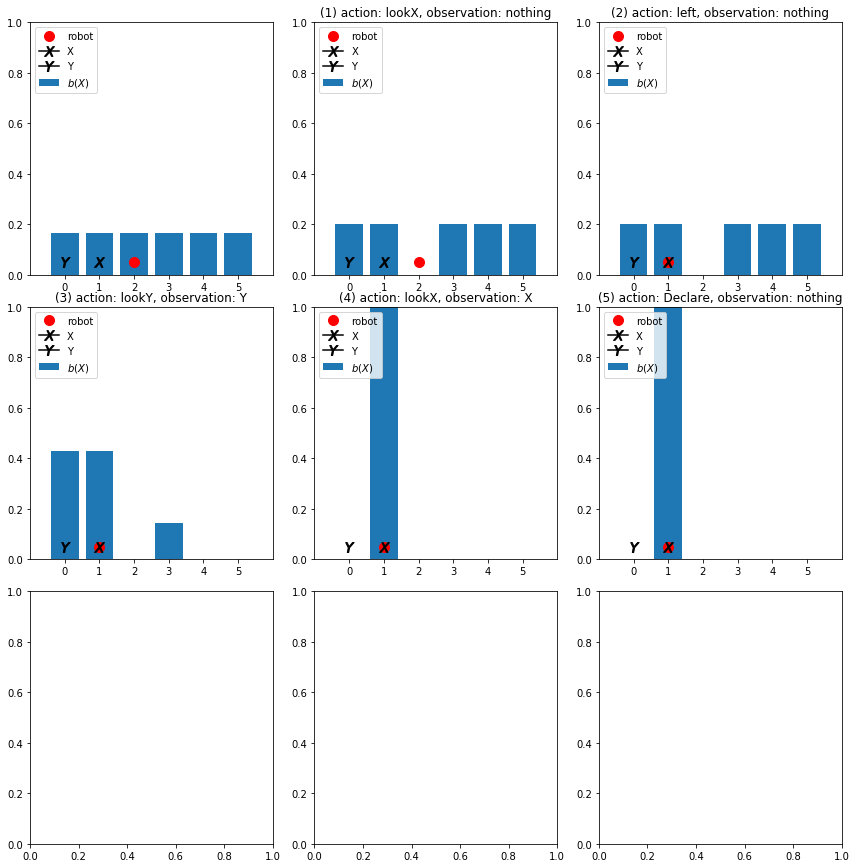

In [44]:
run_domain(solver="sarsop", setting=simple3,
          spatial_corr_func=spatially_close,
          range_x=range_x, range_y=range_y,
          using_jupyter=True)

Output of SARSOP. Precision of 0 is reached.
```
Loading the model ...
  input file   : ./hallway_search.pomdp
  loading time : 0.08s

SARSOP initializing ...
  initialization time : 0.01s

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0.01    0       0        0          185.413    185.413     5        1        
 0.01    6       50       141.704    168.968    27.264      40       25       
 0.01    11      105      148.048    161.647    13.5996     67       44       
 0.01    16      150      148.048    160.047    11.9996     82       58       
 0.01    20      200      148.048    158.323    10.2754     94       72       
 0.01    25      253      148.048    156.589    8.54179     115      87       
 0.02    30      301      148.048    155.934    7.88631     129      103      
 0.02    35      350      148.048    155.131    7.08362     137      117      
 0.02    40      400      148.048    153.797    5.74906     153      124      
 0.02    46      450      148.38     153.03     4.65003     160      130      
 0.03    52      500      148.38     152.42     4.04027     186      138      
 0.03    56      555      149.431    151.653    2.22281     199      145      
 0.03    62      601      149.431    151.224    1.79314     208      148      
 0.04    68      653      149.431    150.81     1.37902     220      152      
 0.04    75      705      149.431    150.294    0.862946    232      155      
 0.04    80      750      149.431    150.086    0.655298    229      157      
 0.05    86      800      149.431    149.79     0.358968    237      160      
 0.05    88      823      149.781    149.781    0           241      162      
-------------------------------------------------------------------------------

SARSOP finishing ...
  target precision reached
  target precision  : 0.000000
  precision reached : 0.000000 

-------------------------------------------------------------------------------
 Time   |#Trial |#Backup |LBound    |UBound    |Precision  |#Alphas |#Beliefs  
-------------------------------------------------------------------------------
 0.05    88      823      149.781    149.781    0           238      162      
-------------------------------------------------------------------------------
```

#### Why doesn't the robot lookY first?** (simple3_2)

Let's compare the belief state conditioned on every possible observation for lookX and lookY.

In [63]:
# Uniform prior
def initialize_belief(setting, spatial_corr_func):
    """
    This is done by scraping some code in main() of hallway_xy.
    Needs to create an Agent to be safe in the state space construction.
    """
    true_r, true_x, true_y, hallway_length = str_to_setting(setting)
    variables = ["X", "Y"]
    weights = [
        ((x, y), indicator(spatial_corr_func(x, y)))
        for x in range(hallway_length)
        for y in range(hallway_length)
    ]
    joint_dist = TabularDistribution(variables, weights)
    agent = HSAgent(hallway_length,
                    None,
                    joint_dist,
                    range_x,
                    range_y)
    # uniform belief over x but true belief over r.
    init_belief_hist = {}
    for state in agent.transition_model.get_all_states():
        if state.r == true_r:
            init_belief_hist[state] = 1.0 / hallway_length
        else:
            init_belief_hist[state] = 0.0
    return pomdp_py.Histogram(init_belief_hist), agent

def update_belief(agent, belief, action, observation):
    new_belief = pomdp_py.update_histogram_belief(belief,
                                                  action, observation,
                                                  agent.observation_model,
                                                  agent.transition_model)
    return new_belief
    

In [64]:
setting = simple3
true_r, true_x, true_y, hallway_length = str_to_setting(setting)
init_state = HSTrueState(true_r, true_x, true_y)
spatial_corr_func = spatially_close
init_belief, agent = initialize_belief(setting, spatially_close)

**Initial belief**

Text(0.5, 1.0, 'initial belief')

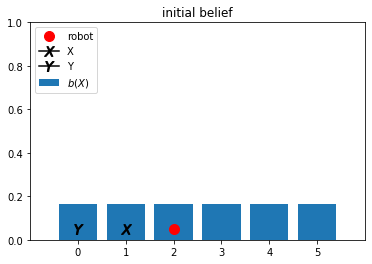

In [80]:
plot_belief(init_belief, plt.gca(), hallway_length)
plot_true_state(init_state, plt.gca())
plt.title("initial belief")

**If action = lookX, observation=X:**

The plot below means observing X is very attractive; The belief _b(X)_ concentrates at one location after update.

Text(0.5, 1.0, 'action: lookX, observation: X')

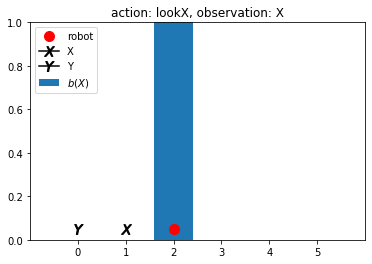

In [79]:
updated_belief1 = update_belief(agent, init_belief, HSAction("lookX"), HSObservation("X"))
plot_belief(updated_belief1, plt.gca(), hallway_length)
plot_true_state(init_state, plt.gca())
plt.title("action: lookX, observation: X")

**If action = lookX, observation=nothing:**

Observing `nothing` helps, as we expect, by eliminating the probability at one location.

Text(0.5, 1.0, 'action: lookX, observation: nothing')

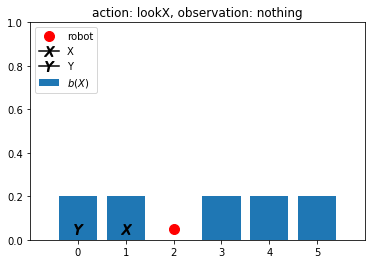

In [78]:
updated_belief2 = update_belief(agent, init_belief, HSAction("lookX"), HSObservation("nothing"))
plot_belief(updated_belief2, plt.gca(), hallway_length)
plot_true_state(init_state, plt.gca())
plt.title("action: lookX, observation: nothing")

**If action = lookY, observation=Y:**

Observing `Y`, as shown below, helps, due to the `spatially_close` correlation. However, it is still quite uncertain, compared to observing `X` when taking lookX.

Text(0.5, 1.0, 'action: lookY, observation: Y')

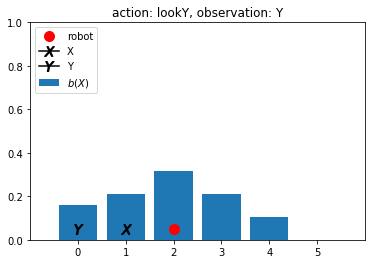

In [77]:
updated_belief3 = update_belief(agent, init_belief, HSAction("lookY"), HSObservation("Y"))
plot_belief(updated_belief3, plt.gca(), hallway_length)
plot_true_state(init_state, plt.gca())
plt.title("action: lookY, observation: Y")

**If action = lookY, observation = nothing**

Interestingly, observing `nothing` when lookY, in this setting, has a similar effect as observing `nothing` when lookX. This one might be slightly better because the belief is not uniform. However, together with the case above, lookY does not seem as attractive as lookX, primarily because lookX may give you a peaked belief

Text(0.5, 1.0, 'action: lookY, observation: nothing')

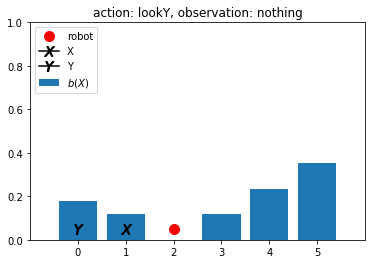

In [76]:
updated_belief4 = update_belief(agent, init_belief, HSAction("lookY"), HSObservation("nothing"))
plot_belief(updated_belief4, plt.gca(), hallway_length)
plot_true_state(init_state, plt.gca())
plt.title("action: lookY, observation: nothing")

### Simple setting, spatially independent
```
def spatially_independent(x, y):
    return True
```

YR.X
[step=1] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
Y.RX
[step=2] action=right, observation=nothing, reward=0, cum_reward=0.00000
Y.RX
[step=3] action=lookX, observation=nothing, reward=0, cum_reward=0.00000
Y..R
[step=4] action=right, observation=nothing, reward=0, cum_reward=0.00000
Y..R
[step=5] action=lookX, observation=X, reward=0, cum_reward=0.00000
Y..R
[step=6] action=Declare, observation=nothing, reward=10, cum_reward=7.73781
Done. Discounted cumulative reward: 7.73781


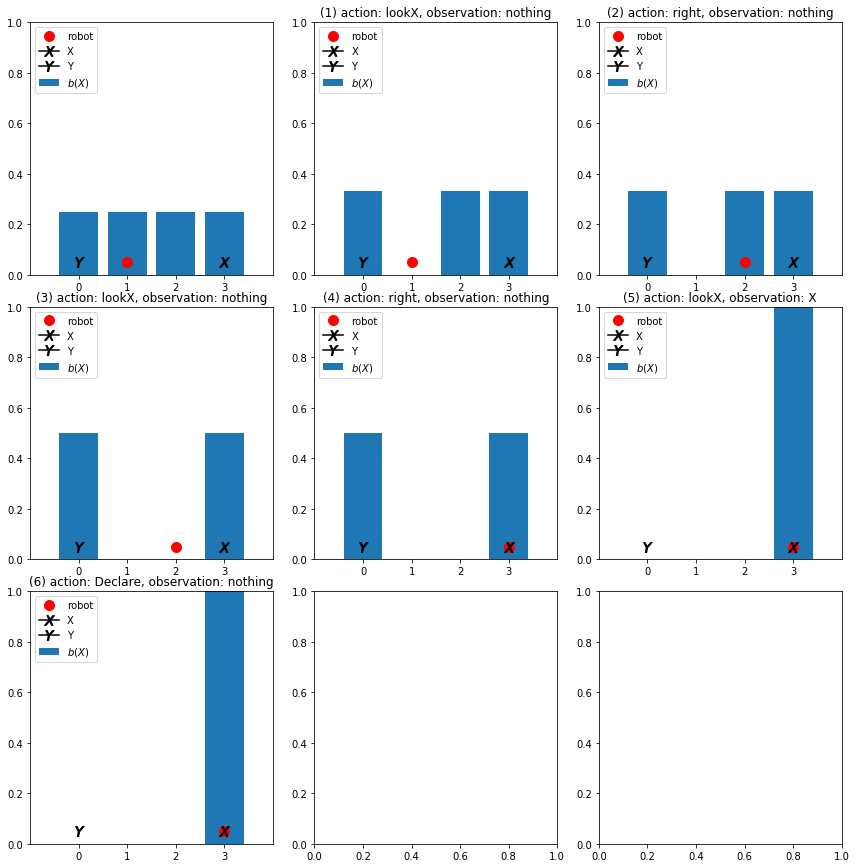

In [34]:
run_domain(solver="sarsop", setting=simple,
          spatial_corr_func=spatially_independent,
          range_x=range_x, range_y=range_y,
          using_jupyter=True)

Good. When X and Y are independent, then the solver would not take lookY at any time.

## Summary

Our goal was determine whether, roughly speaking, "searching for Y before searching for X" is a kind of behavior that would be optimal. **More precisely, we investigated whether the optimal policy when the task is to search for X involves using a detector for Y prior to actually detecting X, when the robot is given the joint distribution `Pr(X,Y)` and the option to use a detector for Y (i.e. the lookY action) that has a larger range than the detector for X.**

We derived a correlation-based belief update model that incorporates the observation of `Y` (empty or non-empty) into the belief about `X`. **Even though the belief about `Y` is not maintained, the optimal policy indeed involves firing the Y detector.** The behavior varies according to the spatial correlation relation. We tested 4 kinds:
* spatially close
* spatially apart
* spatially exact
* spatially independent

**We used the "spatially exact" case to study the planner's behavior.** We designed a setting where the first optimal action must be lookY, and we determined the optimal sequence of action under a POMDP policy in that setting. We observed that SARSOP / VI are able to produce optimal behavior (SARSOP does so when the precision goes to near zero), while POUCT fails to do so; POUCT failed to take lookY (with 2000 simulations). We used SARSOP for the remaining evaluations because it efficiently computes the optimal policy for this toy domain.

**In "spatially apart" we found a case (quite arbitrarily) where taking lookY first is optimal.**

**For "spatially close",** we observed a case where lookY is not optimal in the beginning, but is optimal at some point during the search. **We analyzed why initially, lookY isn't as good as lookX** by looking at the resulting beliefs after receiving all possible observations following either action.

**In "spatially independent" we observed, as expected, that the optimal policy does not involve the use of lookY** - because doing so does not help searching for X.

We conclude that using the detector for a spatially correlated object is part of the optimal policy in a number of cases. The optimal POMDP solver will figure out when to fire that detector. But, even for SARSOP, it does not scale beyond a hallway of length 6 or 7. It would be interesting to see if the agent 